In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib

In [ ]:
dataset_url = "/content/drive/MyDrive/Datasets/train/"

In [ ]:
data_dir = pathlib.Path(dataset_url)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))

In [ ]:
image_count

1132

In [ ]:
leaves = list(data_dir.glob('leaf/*'))

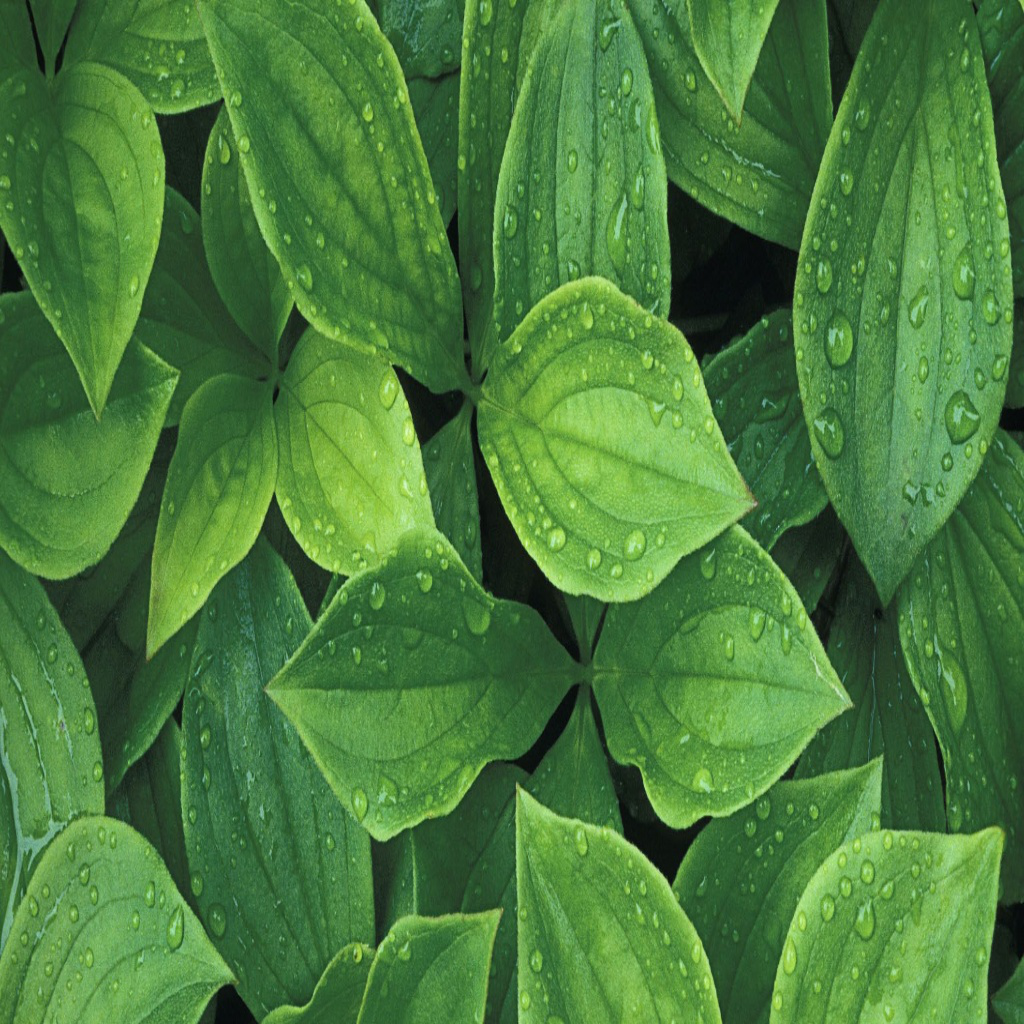

In [ ]:
PIL.Image.open(str(leaves[0]))

In [ ]:
batch_size = 28
img_height = 480
img_width = 480

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1132 files belonging to 1 classes.
Using 906 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1132 files belonging to 1 classes.
Using 226 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['leaf']


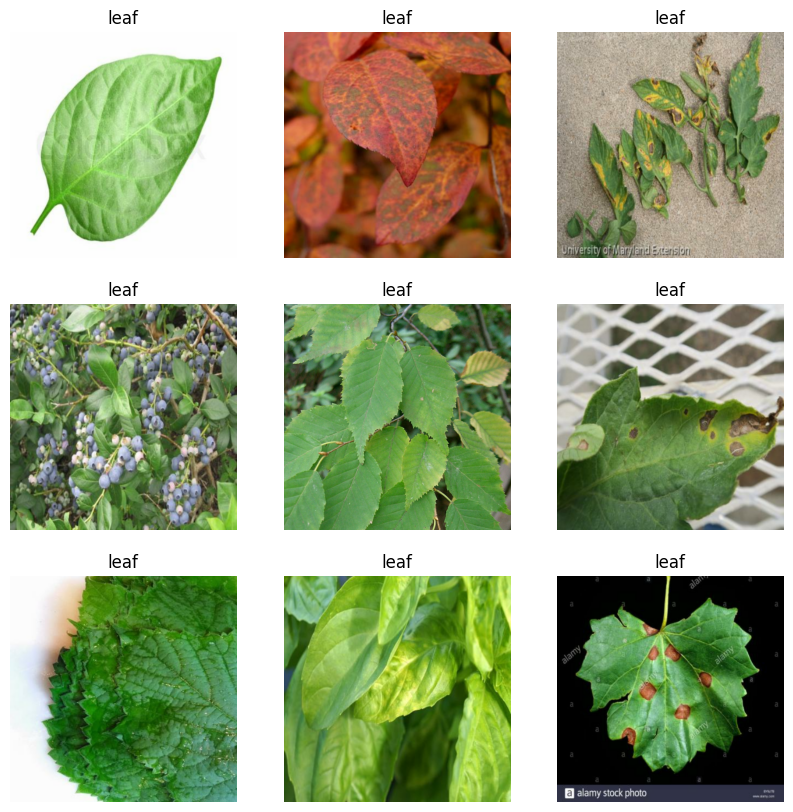

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(28, 480, 480, 3)
(28,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 480, 480, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 480, 480, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 240, 240, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 240, 240, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 120, 120, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 64)      1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
33/33 [==============================] - 25s 258ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
33/33 [==============================] - 4s 108ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
33/33 [==============================] - 3s 108ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
33/33 [==============================] - 4s 118ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
33/33 [==============================] - 3s 106ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
33/33 [==============================] - 4s 118ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
33/33 [==============================] - 5s 142ms/step - loss: 0.0000e+00 - accuracy: 1.

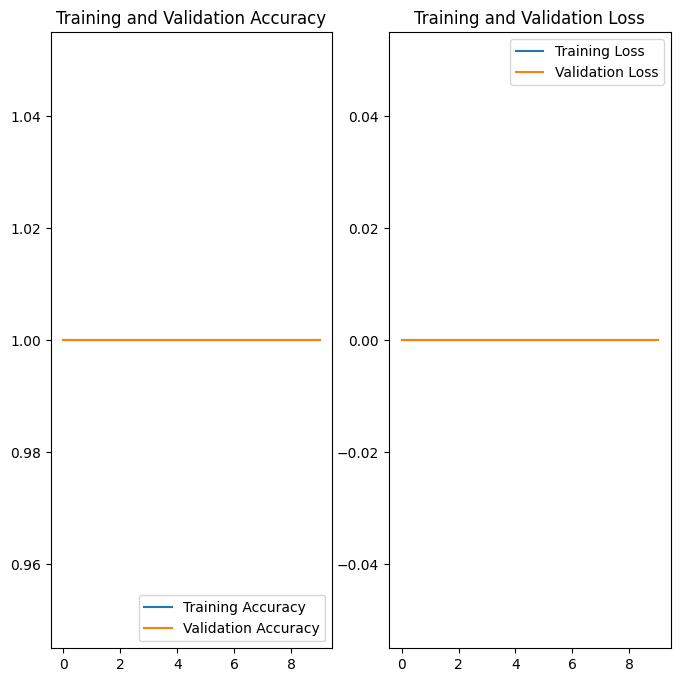

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

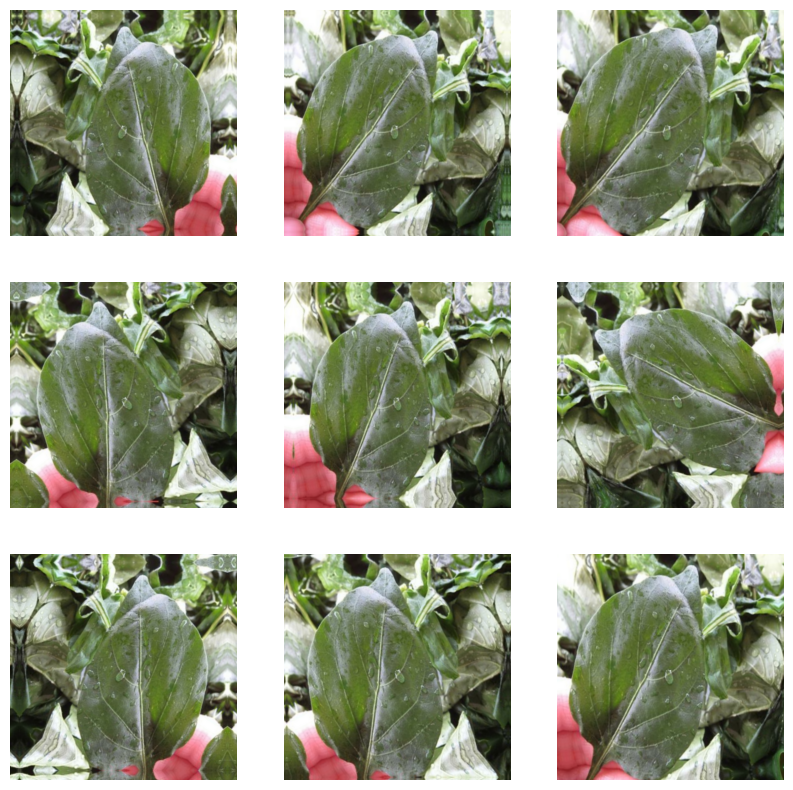

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 480, 480, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 480, 480, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 480, 480, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 240, 240, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 240, 240, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 120, 120, 32)     0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
33/33 [==============================] - 9s 203ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/15
33/33 [==============================] - 6s 185ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/15
33/33 [==============================] - 6s 187ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/15
33/33 [==============================] - 6s 185ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/15
33/33 [==============================] - 6s 197ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/15
33/33 [==============================] - 6s 194ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/15
33/33 [==============================] - 6s 196ms/step - loss: 0.0000e+00 - accuracy: 1.0

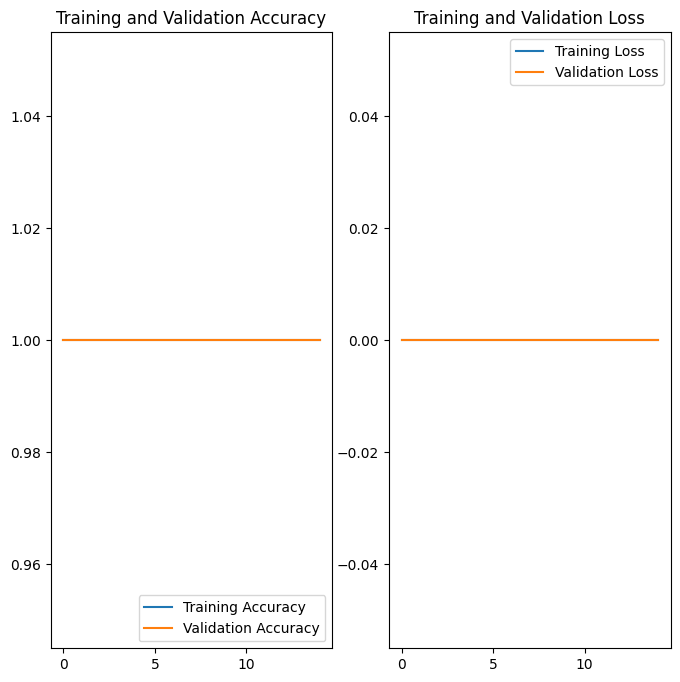

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [126]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
!pip3 install tflite_support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 26.9 MB/s eta 0:00:00


In [127]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

""" ... """
"""Creates the metadata for an image classifier."""

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "image classifier"
model_meta.description = ("Identify the most prominent object in the "
                          "image from a set of 1 categories such as "
                          "leafs.")
model_meta.version = "v2"
model_meta.author = "TensorFlow"
model_meta.license = ("Apache License. Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

In [128]:
import os

In [129]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [130]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(160, 160))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [131]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "probability"
output_meta.description = "Probabilities of the 1001 labels respectively."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("/content/drive/MyDrive/label.txt")
label_file.description = "Labels for objects that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

In [132]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [133]:
populator = _metadata.MetadataPopulator.with_model_file("/content/drive/MyDrive/model.tflite")
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["/content/drive/MyDrive/label.txt"])
populator.populate()